<font size="6">
<b><u>Early Detection of failures in Gears</u></b><br>
</font>
<font size="4">
<b><u>Final Project Program</u></b><br>
<u>Authors:</u><br>
Ayush Prasad 22B0674<br>
Yash Tangri 22B2251<br>
Aditi Agrawal 22B2134<br>
</font>

In [2]:
import numpy as np            #importing all the necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')


<font size="4">
We use the <b>sklearn</b> library for all the different classification models. Apart from that we use <b>matplotlib</b> library to plot the graphs and the <b>seaborn</b> library for plotting the heatmaps
</font>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Reading all the csv files
df_no_fault = pd.read_csv('no_fault.csv')
df_ecc = pd.read_csv('eccentricity.csv')
df_miss_tooth = pd.read_csv('missing_tooth.csv')
df_root_crack = pd.read_csv('root_crack.csv')
df_surf_fault = pd.read_csv('surface_fault.csv')
df_tooth_chip = pd.read_csv('tooth_chipped_fault.csv')

In [ ]:
df_no_fault #displaying the file

,sensor1,sensor2,time_x,speedSet,load_value,gear_fault_desc
0,2.523465,2.430168,2023-05-03 21:47:31.000000,8.332031,0,No fault
1,2.521494,2.430003,2023-05-03 21:47:31.000200,8.332031,0,No fault
2,2.522479,2.429675,2023-05-03 21:47:31.000400,8.332031,0,No fault
3,2.521330,2.431810,2023-05-03 21:47:31.000600,8.332031,0,No fault
4,2.522479,2.431317,2023-05-03 21:47:31.000800,8.332031,0,No fault
...,...,...,...,...,...,...
149995,2.549417,2.441830,2023-05-03 22:06:06.999000,40.000000,80,No fault
149996,2.496363,2.453820,2023-05-03 22:06:06.999200,40.000000,80,No fault
149997,2.520837,2.418505,2023-05-03 22:06:06.999400,40.000000,80,No fault
149998,2.499319,2.417027,2023-05-03 22:06:06.999600,40.000000,80,No fault


In [ ]:
df = [df_no_fault, df_ecc, df_miss_tooth, df_root_crack, df_surf_fault, df_tooth_chip] # Create a list containing DataFrames from various CSV files

for i in df:   # Iterate over each DataFrame in the list
    i[['date', 'time']] = i['time_x'].str.split(' ', expand=True)   # Split the 'time_x' column into 'date' and 'time' columns based on space
    i['date'] = pd.to_datetime(i['date'])  # Convert the 'date' column to datetime format
    i.drop('time_x', axis=1, inplace=True)  # Remove the original 'time_x' column as it's no longer needed


<font size="4">
Now, we have vibration data for each gear across the x and y direction. The data is saved in the columns sensor1 and sensor2. So, we calulated the net vibration displacement as <br>
$vibration\ \ displacement = \sqrt{(sensor1^2 + sensor2^2)}$


In [ ]:
#Vibration displacement will be equal to the net displacement of the two sensors
#vib_disp = sqrt(sensor1^2 + sensor2^2)
for i in df:  # Iterate over each DataFrame in the collection
    i['vib_disp'] = np.sqrt(i['sensor1']**2 + i['sensor2']**2)
    i.drop(['sensor1', 'sensor2'], axis=1, inplace=True) # Remove 'sensor1' and 'sensor2' columns as they are no longer needed
    i.drop('date', axis=1, inplace=True)   # Remove 'date' column if present, it's not necessary for further analysis

In [ ]:
df_no_fault

,speedSet,load_value,gear_fault_desc,time,vib_disp
0,8.332031,0,No fault,21:47:31.000000,3.503368
1,8.332031,0,No fault,21:47:31.000200,3.501835
2,8.332031,0,No fault,21:47:31.000400,3.502317
3,8.332031,0,No fault,21:47:31.000600,3.502971
4,8.332031,0,No fault,21:47:31.000800,3.503456
...,...,...,...,...,...
149995,40.000000,80,No fault,22:06:06.999000,3.530164
149996,40.000000,80,No fault,22:06:06.999200,3.500437
149997,40.000000,80,No fault,22:06:06.999400,3.493392
149998,40.000000,80,No fault,22:06:06.999600,3.476869


In [ ]:
# defining a function which takes in input of
def df_speed_load(df, speed_value, load_value):
    # Filter dataframe based on specified speed and load values
    df_new = df[(df['speedSet'] == speed_value) & (df['load_value'] == load_value)]

    # Convert time strings to datetime objects for calculation
    time1 = datetime.strptime(df_new['time'].iloc[-1], '%H:%M:%S.%f')
    time2 = datetime.strptime(df_new['time'].iloc[0], '%H:%M:%S.%f')

    # Calculate the time difference in seconds
    time_diff = time1-time2
    seconds = time_diff.total_seconds()

    # Generate an array of time values corresponding to the dataframe
    time_array = np.linspace(0, seconds, len(df_new))
    df_new['time'] = time_array

    # Reset the index of the filtered dataframe
    df_new = df_new.reset_index(drop=True)

    # Extract vibration data for analysis
    vibration_data = df_new['vib_disp']

    # Calculate statistical features of the vibration data
    features = {
        'mean': np.mean(vibration_data),
        'std': np.std(vibration_data),
        'skewness': skew(vibration_data),
        'kurtosis': kurtosis(vibration_data),
        'num_peaks': len(find_peaks(vibration_data)[0]),
    }

    # Add calculated statistical features to the dataframe
    df_new['mean'] = features['mean']
    df_new['std'] = features['std']
    df_new['skewness'] = features['skewness']
    df_new['kurtosis'] = features['kurtosis']
    df_new['num_peaks'] = features['num_peaks']

    # plt.figure(figsize=(10, 6))
    # plt.plot(df_new['time'], df_new['vib_disp'])

    # plt.title('Vibration vs Time for speed {} and load {}'.format(speed_value, load_value))
    # plt.xlabel('Time')
    # plt.ylabel('Vibration')
    # plt.show()

    # Return the modified dataframe with added statistical features
    return df_new

In [ ]:
#No fault data divided on the basis of speed and Load
df_no_fault_8_0 = df_speed_load(df_no_fault, 8.33203125, 0)
df_no_fault_8_80 = df_speed_load(df_no_fault, 8.33203125, 80)
df_no_fault_25_0 = df_speed_load(df_no_fault, 25, 0)
df_no_fault_25_80 = df_speed_load(df_no_fault, 25, 80)
df_no_fault_40_0 = df_speed_load(df_no_fault, 40, 0)
df_no_fault_40_80 = df_speed_load(df_no_fault, 40, 80)

# Concatenate all divided dataframes into one dataframe for no fault data
df_no_fault = pd.concat([df_no_fault_8_0, df_no_fault_8_80, df_no_fault_25_0, df_no_fault_25_80, df_no_fault_40_0, df_no_fault_40_80])

#Missing Tooth data divided on the basis of speed and Load
df_miss_tooth_8_0 = df_speed_load(df_miss_tooth, 8.33203125, 0)
df_miss_tooth_8_80 = df_speed_load(df_miss_tooth, 8.33203125, 80)
df_miss_tooth_25_0 = df_speed_load(df_miss_tooth, 25, 0)
df_miss_tooth_25_80 = df_speed_load(df_miss_tooth, 25, 80)
df_miss_tooth_40_0 = df_speed_load(df_miss_tooth, 40, 0)
df_miss_tooth_40_80 = df_speed_load(df_miss_tooth, 40, 80)

# Concatenate all divided dataframes into one dataframe for missing tooth data
df_miss_tooth = pd.concat([df_miss_tooth_8_0, df_miss_tooth_8_80, df_miss_tooth_25_0, df_miss_tooth_25_80, df_miss_tooth_40_0, df_miss_tooth_40_80])

#Eccentricity data divided on the basis of speed and Load
df_ecc_8_0 = df_speed_load(df_ecc, 8.33203125, 0)
df_ecc_8_80 = df_speed_load(df_ecc, 8.33203125, 80)
df_ecc_25_0 = df_speed_load(df_ecc, 25, 0)
df_ecc_25_80 = df_speed_load(df_ecc, 25, 80)
df_ecc_40_0 = df_speed_load(df_ecc, 40, 0)
df_ecc_40_80 = df_speed_load(df_ecc, 40, 80)

# Concatenate all divided dataframes into one dataframe for eccentricity data
df_ecc = pd.concat([df_ecc_8_0, df_ecc_8_80, df_ecc_25_0, df_ecc_25_80, df_ecc_40_0, df_ecc_40_80])

#Root crack data divided on the basis of speed and Load
df_root_crack_8_0 = df_speed_load(df_root_crack, 8.33203125, 0)
df_root_crack_8_80 = df_speed_load(df_root_crack, 8.33203125, 80)
df_root_crack_25_0 = df_speed_load(df_root_crack, 25, 0)
df_root_crack_25_80 = df_speed_load(df_root_crack, 25, 80)
df_root_crack_40_0 = df_speed_load(df_root_crack, 40, 0)
df_root_crack_40_80 = df_speed_load(df_root_crack, 40, 80)

# Concatenate all divided dataframes into one dataframe for root crack data
df_root_crack = pd.concat([df_root_crack_8_0, df_root_crack_8_80, df_root_crack_25_0, df_root_crack_25_80, df_root_crack_40_0, df_root_crack_40_80])

#Tooth chipped fault data divided on the basis of speed and Load
df_tooth_chip_8_0 = df_speed_load(df_tooth_chip, 8.33203125, 0)
df_tooth_chip_8_80 = df_speed_load(df_tooth_chip, 8.33203125, 80)
df_tooth_chip_25_0 = df_speed_load(df_tooth_chip, 25, 0)
df_tooth_chip_25_80 = df_speed_load(df_tooth_chip, 25, 80)
df_tooth_chip_40_0 = df_speed_load(df_tooth_chip, 40, 0)
df_tooth_chip_40_80 = df_speed_load(df_tooth_chip, 40, 80)

# Concatenate all divided dataframes into one dataframe for tooth chipped fault data
df_tooth_chip = pd.concat([df_tooth_chip_8_0, df_tooth_chip_8_80, df_tooth_chip_25_0, df_tooth_chip_25_80, df_tooth_chip_40_0, df_tooth_chip_40_80])

#Surface Fault data divided on the basis of speed and Load
df_surf_fault_8_0 = df_speed_load(df_surf_fault, 8.33203125, 0)
df_surf_fault_8_80 = df_speed_load(df_surf_fault, 8.33203125, 80)
df_surf_fault_25_0 = df_speed_load(df_surf_fault, 25, 0)
df_surf_fault_25_80 = df_speed_load(df_surf_fault, 25, 80)
df_surf_fault_40_0 = df_speed_load(df_surf_fault, 40, 0)
df_surf_fault_40_80 = df_speed_load(df_surf_fault, 40, 80)

# Concatenate all divided dataframes into one dataframe for surface fault data
df_surf_fault = pd.concat([df_surf_fault_8_0, df_surf_fault_8_80, df_surf_fault_25_0, df_surf_fault_25_80, df_surf_fault_40_0, df_surf_fault_40_80])


In [ ]:

# Create dictionaries to store vibration displacement data for each fault type, speed, and load combination
data_no_fault_disp = {"df_no_fault_8_0":df_no_fault_8_0['vib_disp'],
                 "df_no_fault_8_80":df_no_fault_8_80['vib_disp'],
                 "df_no_fault_25_0":df_no_fault_25_0['vib_disp'],
                 "df_no_fault_25_80":df_no_fault_25_80['vib_disp'],
                 "df_no_fault_40_0":df_no_fault_40_0['vib_disp'],
                 "df_no_fault_40_80":df_no_fault_40_80['vib_disp']}

# Create dictionaries to store time data for each fault type, speed, and load combination
data_no_fault_time = {"df_no_fault_8_0":df_no_fault_8_0['time'],
                 "df_no_fault_8_80":df_no_fault_8_80['time'],
                 "df_no_fault_25_0":df_no_fault_25_0['time'],
                 "df_no_fault_25_80":df_no_fault_25_80['time'],
                 "df_no_fault_40_0":df_no_fault_40_0['time'],
                 "df_no_fault_40_80":df_no_fault_40_80['time']}

# Create a list to store the keys for the above dictionaries
data_no_fault_list = ["df_no_fault_8_0",
                 "df_no_fault_8_80",
                 "df_no_fault_25_0",
                 "df_no_fault_25_80",
                 "df_no_fault_40_0",
                 "df_no_fault_40_80"]

# Similar data structures for other fault types (eccentricity, missing tooth, root crack, tooth chip, and surface fault)

data_ecc_disp = {"df_ecc_8_0":df_ecc_8_0['vib_disp'],
                 "df_ecc_8_80":df_ecc_8_80['vib_disp'],
                 "df_ecc_25_0":df_ecc_25_0['vib_disp'],
                 "df_ecc_25_80":df_ecc_25_80['vib_disp'],
                 "df_ecc_40_0":df_ecc_40_0['vib_disp'],
                 "df_ecc_40_80":df_ecc_40_80['vib_disp']}

data_ecc_time = {"df_ecc_8_0":df_ecc_8_0['time'],
                 "df_ecc_8_80":df_ecc_8_80['time'],
                 "df_ecc_25_0":df_ecc_25_0['time'],
                 "df_ecc_25_80":df_ecc_25_80['time'],
                 "df_ecc_40_0":df_ecc_40_0['time'],
                 "df_ecc_40_80":df_ecc_40_80['time']}

data_ecc_list = ["df_ecc_8_0",
                 "df_ecc_8_80",
                 "df_ecc_25_0",
                 "df_ecc_25_80",
                 "df_ecc_40_0",
                 "df_ecc_40_80"]

data_miss_tooth_disp = {"df_miss_tooth_8_0":df_miss_tooth_8_0['vib_disp'],
                 "df_miss_tooth_8_80":df_miss_tooth_8_80['vib_disp'],
                 "df_miss_tooth_25_0":df_miss_tooth_25_0['vib_disp'],
                 "df_miss_tooth_25_80":df_miss_tooth_25_80['vib_disp'],
                 "df_miss_tooth_40_0":df_miss_tooth_40_0['vib_disp'],
                 "df_miss_tooth_40_80":df_miss_tooth_40_80['vib_disp']}

data_miss_tooth_time = {"df_miss_tooth_8_0":df_miss_tooth_8_0['time'],
                 "df_miss_tooth_8_80":df_miss_tooth_8_80['time'],
                 "df_miss_tooth_25_0":df_miss_tooth_25_0['time'],
                 "df_miss_tooth_25_80":df_miss_tooth_25_80['time'],
                 "df_miss_tooth_40_0":df_miss_tooth_40_0['time'],
                 "df_miss_tooth_40_80":df_miss_tooth_40_80['time']}

data_miss_tooth_list = ["df_miss_tooth_8_0",
                 "df_miss_tooth_8_80",
                 "df_miss_tooth_25_0",
                 "df_miss_tooth_25_80",
                 "df_miss_tooth_40_0",
                 "df_miss_tooth_40_80"]

data_root_crack_disp = {"df_root_crack_8_0":df_root_crack_8_0['vib_disp'],
                 "df_root_crack_8_80":df_root_crack_8_80['vib_disp'],
                 "df_root_crack_25_0":df_root_crack_25_0['vib_disp'],
                 "df_root_crack_25_80":df_root_crack_25_80['vib_disp'],
                 "df_root_crack_40_0":df_root_crack_40_0['vib_disp'],
                 "df_root_crack_40_80":df_root_crack_40_80['vib_disp']}

data_root_crack_time = {"df_root_crack_8_0":df_root_crack_8_0['time'],
                 "df_root_crack_8_80":df_root_crack_8_80['time'],
                 "df_root_crack_25_0":df_root_crack_25_0['time'],
                 "df_root_crack_25_80":df_root_crack_25_80['time'],
                 "df_root_crack_40_0":df_root_crack_40_0['time'],
                 "df_root_crack_40_80":df_root_crack_40_80['time']}

data_root_crack_list = ["df_root_crack_8_0",
                 "df_root_crack_8_80",
                 "df_root_crack_25_0",
                 "df_root_crack_25_80",
                 "df_root_crack_40_0",
                 "df_root_crack_40_80"]

data_tooth_chip_disp = {"df_tooth_chip_8_0":df_tooth_chip_8_0['vib_disp'],
                 "df_tooth_chip_8_80":df_tooth_chip_8_80['vib_disp'],
                 "df_tooth_chip_25_0":df_tooth_chip_25_0['vib_disp'],
                 "df_tooth_chip_25_80":df_tooth_chip_25_80['vib_disp'],
                 "df_tooth_chip_40_0":df_tooth_chip_40_0['vib_disp'],
                 "df_tooth_chip_40_80":df_tooth_chip_40_80['vib_disp']}

data_tooth_chip_time = {"df_tooth_chip_8_0":df_tooth_chip_8_0['time'],
                 "df_tooth_chip_8_80":df_tooth_chip_8_80['time'],
                 "df_tooth_chip_25_0":df_tooth_chip_25_0['time'],
                 "df_tooth_chip_25_80":df_tooth_chip_25_80['time'],
                 "df_tooth_chip_40_0":df_tooth_chip_40_0['time'],
                 "df_tooth_chip_40_80":df_tooth_chip_40_80['time']}

data_tooth_chip_list = ["df_tooth_chip_8_0",
                 "df_tooth_chip_8_80",
                 "df_tooth_chip_25_0",
                 "df_tooth_chip_25_80",
                 "df_tooth_chip_40_0",
                 "df_tooth_chip_40_80"]

data_surf_fault_disp = {"df_surf_fault_8_0":df_surf_fault_8_0['vib_disp'],
                 "df_surf_fault_8_80":df_surf_fault_8_80['vib_disp'],
                 "df_surf_fault_25_0":df_surf_fault_25_0['vib_disp'],
                 "df_surf_fault_25_80":df_surf_fault_25_80['vib_disp'],
                 "df_surf_fault_40_0":df_surf_fault_40_0['vib_disp'],
                 "df_surf_fault_40_80":df_surf_fault_40_80['vib_disp']}

data_surf_fault_time = {"df_surf_fault_8_0":df_surf_fault_8_0['time'],
                 "df_surf_fault_8_80":df_surf_fault_8_80['time'],
                 "df_surf_fault_25_0":df_surf_fault_25_0['time'],
                 "df_surf_fault_25_80":df_surf_fault_25_80['time'],
                 "df_surf_fault_40_0":df_surf_fault_40_0['time'],
                 "df_surf_fault_40_80":df_surf_fault_40_80['time']}

data_surf_fault_list = ["df_surf_fault_8_0",
                 "df_surf_fault_8_80",
                 "df_surf_fault_25_0",
                 "df_surf_fault_25_80",
                 "df_surf_fault_40_0",
                 "df_surf_fault_40_80"]

speed = ['8.33203125','25','40']
index = [1,1,2,2,3,3]


#Showing plots of vibrations(of gears with different faults) with time for speeds 8.33, 25 and 40 under loads 0 and 80 N.

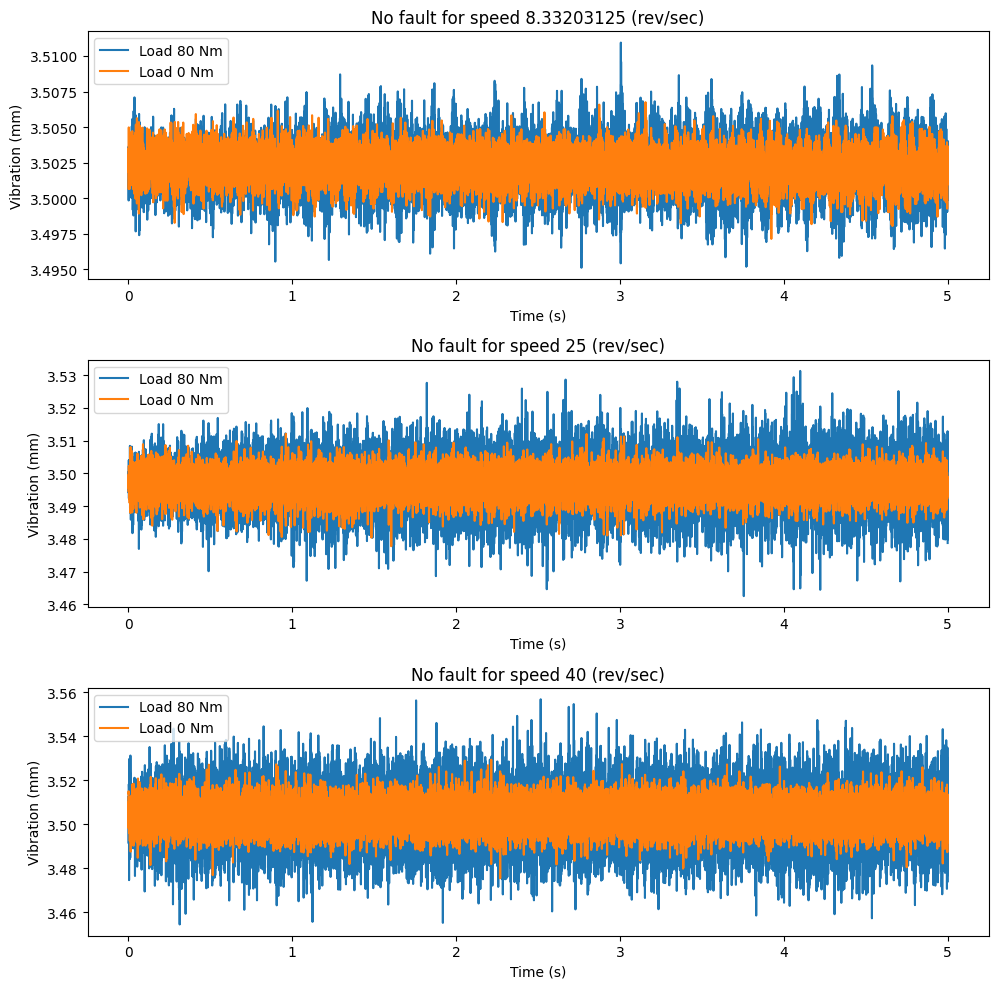

In [ ]:
def show_plots_1():
    # Create a figure with a specific size for plotting multiple subplots
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_no_fault_list),2): # Iterate through the data_no_fault_list to plot each fault type, speed, and load combination
        # Extract vibration displacement and time data for two different loads (0 Nm and 80 Nm)
        y1 = data_no_fault_disp[data_no_fault_list[i]]
        y2 = data_no_fault_disp[data_no_fault_list[i+1]]
        x1 = data_no_fault_time[data_no_fault_list[i]]
        x2 = data_no_fault_time[data_no_fault_list[i+1]]

        # Create a subplot for each combination
        plt.subplot(3,1,int((i/2))+1)

        # Plot vibration displacement against time for both loads
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        # Set title, x-axis label, y-axis label, and legend for the subplot
        plt.title('No fault for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout()   # Adjust layout to prevent overlapping of subplots
    plt.show

show_plots_1()  # Call the function to show the plots



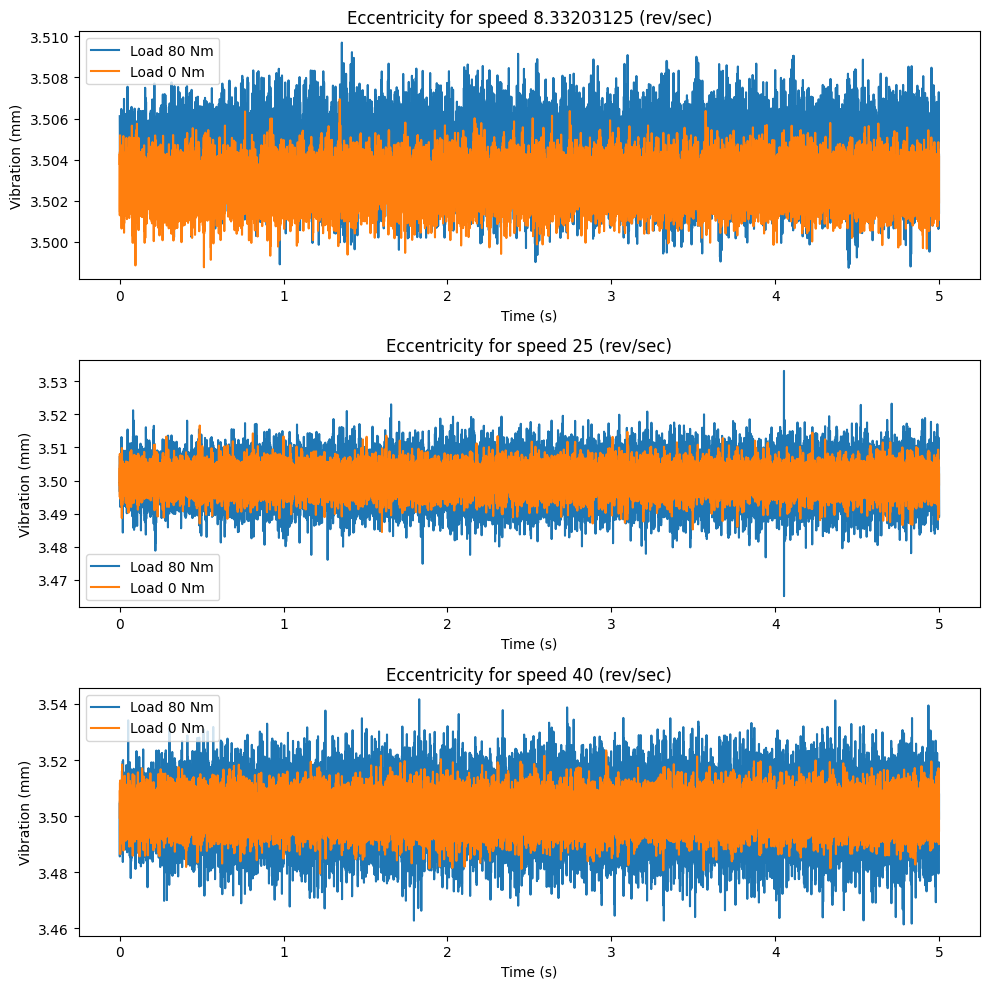

In [ ]:
def show_plots_2():
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_ecc_list),2): # Iterate through the data_ecc_list to plot each fault type, speed, and load combination
        # Extract vibration displacement and time data for two different loads (0 Nm and 80 Nm)
        y1 = data_ecc_disp[data_ecc_list[i]]
        y2 = data_ecc_disp[data_ecc_list[i+1]]
        x1 = data_ecc_time[data_ecc_list[i]]
        x2 = data_ecc_time[data_ecc_list[i+1]]

        # Create a subplot for each combination
        plt.subplot(3,1,int((i/2))+1)
        # Plot vibration displacement against time for both loads
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        # Set title, x-axis label, y-axis label, and legend for the subplot
        plt.title('Eccentricity for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout() # Adjust layout to prevent overlapping of subplots
    plt.show

show_plots_2() # Call the function to show the plots

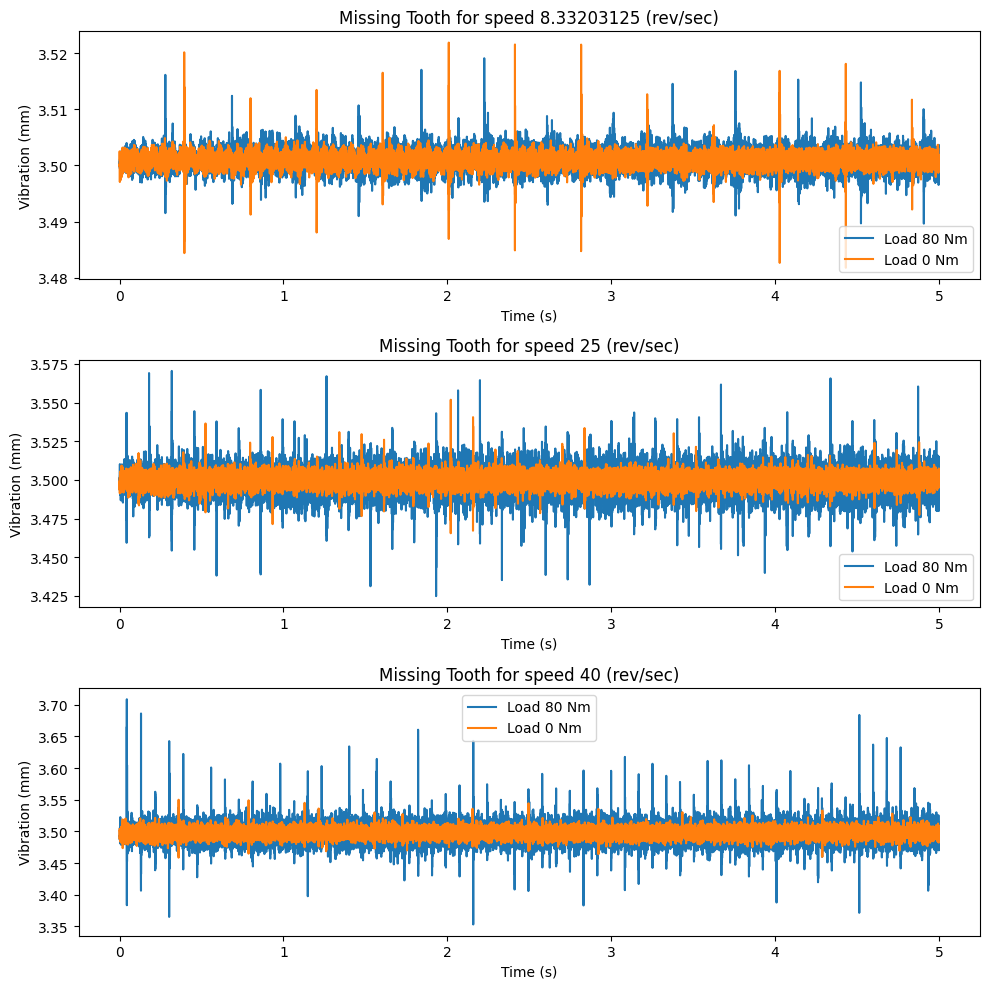

In [ ]:
def show_plots_3():
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_ecc_list),2):
        y1 = data_miss_tooth_disp[data_miss_tooth_list[i]]
        y2 = data_miss_tooth_disp[data_miss_tooth_list[i+1]]
        x1 = data_miss_tooth_time[data_miss_tooth_list[i]]
        x2 = data_miss_tooth_time[data_miss_tooth_list[i+1]]

        plt.subplot(3,1,int((i/2))+1)
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        plt.title('Missing Tooth for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout()
    plt.show

show_plots_3()

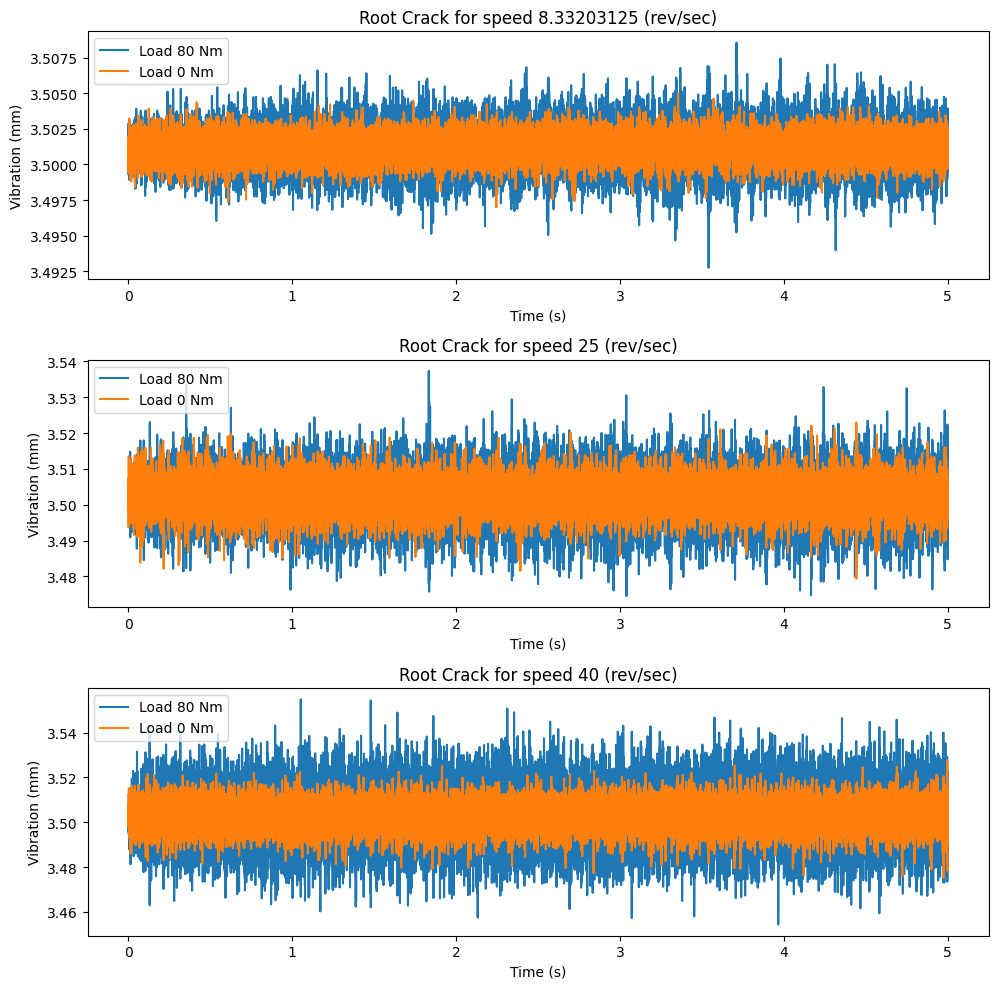

In [ ]:
def show_plots_4():
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_ecc_list),2):
        y1 = data_root_crack_disp[data_root_crack_list[i]]
        y2 = data_root_crack_disp[data_root_crack_list[i+1]]
        x1 = data_root_crack_time[data_root_crack_list[i]]
        x2 = data_root_crack_time[data_root_crack_list[i+1]]

        plt.subplot(3,1,int((i/2))+1)
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        plt.title('Root Crack for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout()
    plt.show

show_plots_4()

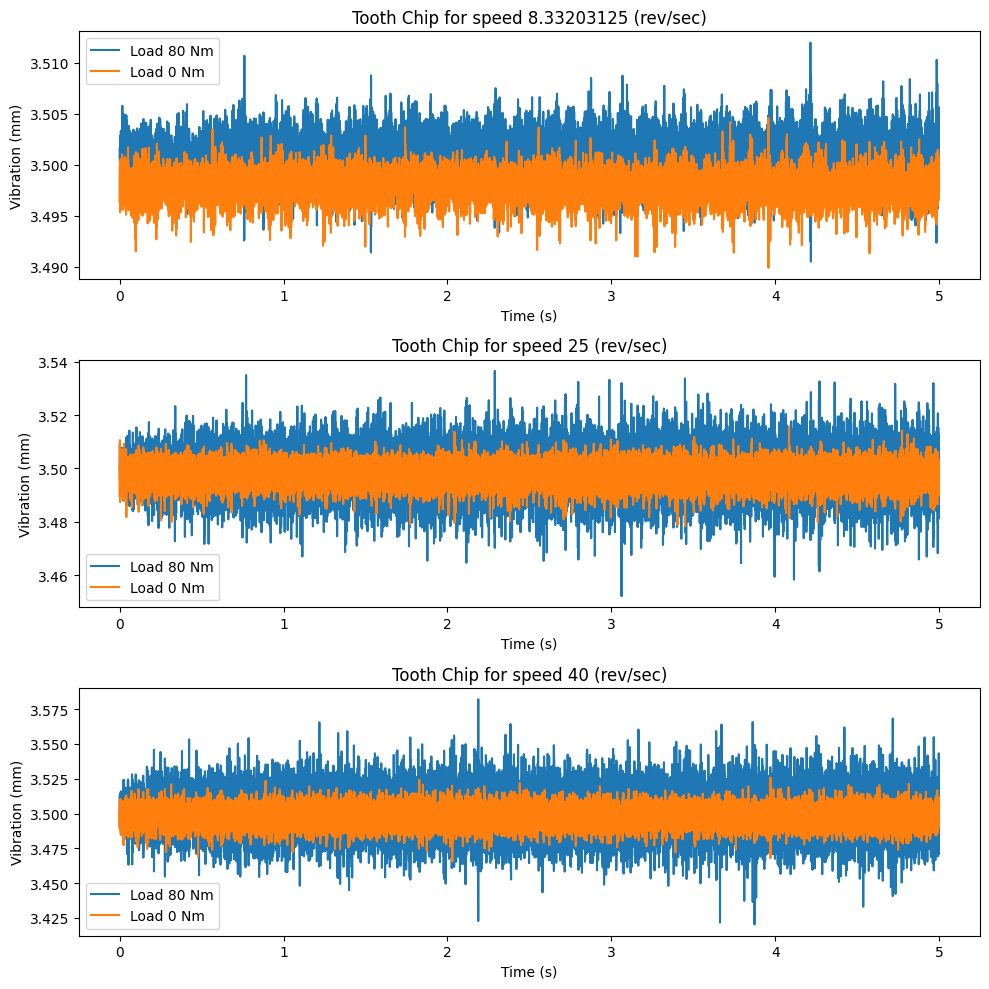

In [ ]:
def show_plots_5():
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_ecc_list),2):
        y1 = data_tooth_chip_disp[data_tooth_chip_list[i]]
        y2 = data_tooth_chip_disp[data_tooth_chip_list[i+1]]
        x1 = data_tooth_chip_time[data_tooth_chip_list[i]]
        x2 = data_tooth_chip_time[data_tooth_chip_list[i+1]]

        plt.subplot(3,1,int((i/2))+1)
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        plt.title('Tooth Chip for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout()
    plt.show

show_plots_5()

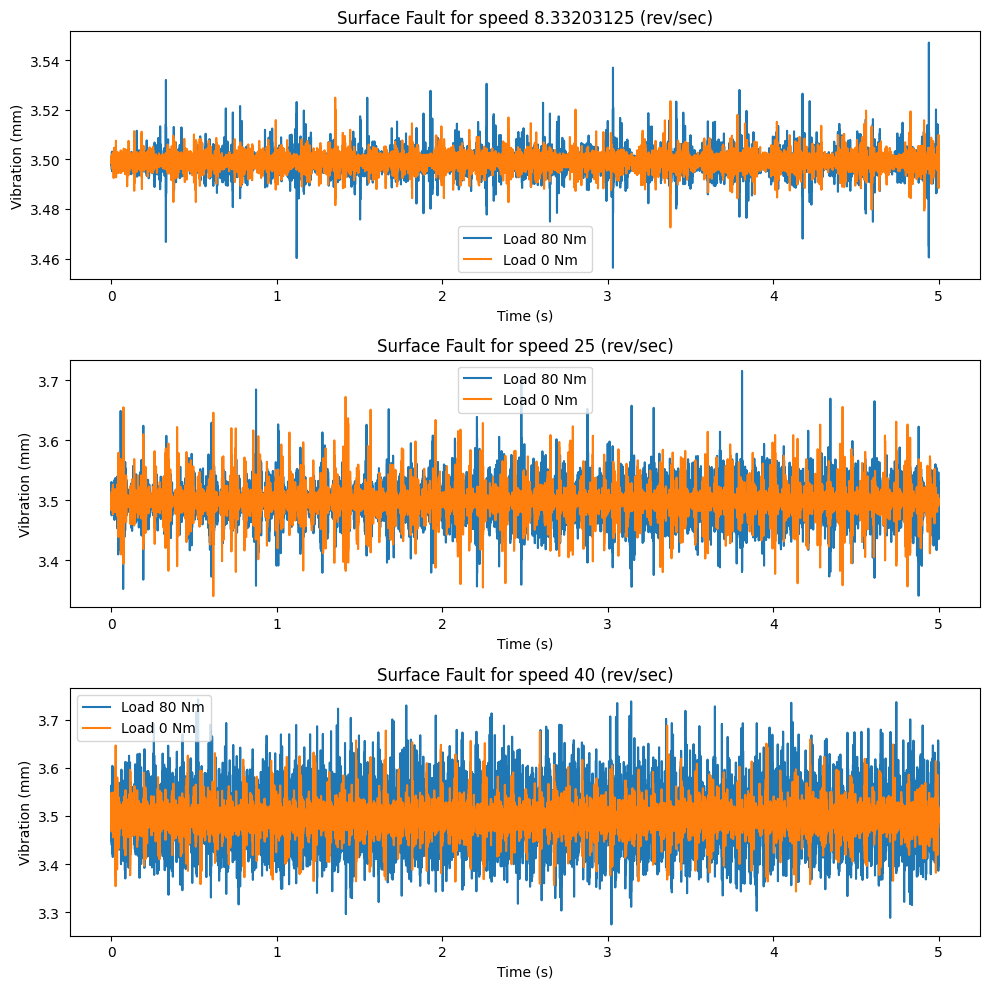

In [ ]:
def show_plots_6():
    plt.figure(figsize=(10,10))
    for i in range(0,len(data_ecc_list),2):
        y1 = data_surf_fault_disp[data_surf_fault_list[i]]
        y2 = data_surf_fault_disp[data_surf_fault_list[i+1]]
        x1 = data_surf_fault_time[data_surf_fault_list[i]]
        x2 = data_surf_fault_time[data_surf_fault_list[i+1]]

        plt.subplot(3,1,int((i/2))+1)
        plt.plot(x2,y2, label="Load 80 Nm")
        plt.plot(x1,y1, label="Load 0 Nm")

        plt.title('Surface Fault for speed ' + speed[int((i/2))] + ' (rev/sec)')
        plt.xlabel('Time (s)')
        plt.ylabel('Vibration (mm)')
        plt.legend()
        plt.tight_layout()
    plt.show

show_plots_6()

In [ ]:
df_total = pd.concat([df_no_fault, df_ecc, df_miss_tooth, df_root_crack, df_surf_fault, df_tooth_chip])
# Concatenate dataframes for different fault conditions into a single dataframe

In [ ]:
df_total = df_total.reset_index(drop=True) # Reset the index of the combined dataframe to ensure consecutive integer indexing
df_total

,speedSet,load_value,gear_fault_desc,time,vib_disp,mean,std,skewness,kurtosis,num_peaks
0,8.332031,0,No fault,0.0000,3.503368,3.502296,0.001000,-0.082738,0.251919,8005
1,8.332031,0,No fault,0.0002,3.501835,3.502296,0.001000,-0.082738,0.251919,8005
2,8.332031,0,No fault,0.0004,3.502317,3.502296,0.001000,-0.082738,0.251919,8005
3,8.332031,0,No fault,0.0006,3.502971,3.502296,0.001000,-0.082738,0.251919,8005
4,8.332031,0,No fault,0.0008,3.503456,3.502296,0.001000,-0.082738,0.251919,8005
...,...,...,...,...,...,...,...,...,...,...
899995,40.000000,80,chipped tooth,4.9990,3.500267,3.501044,0.014812,-0.027105,0.436593,9084
899996,40.000000,80,chipped tooth,4.9992,3.501388,3.501044,0.014812,-0.027105,0.436593,9084
899997,40.000000,80,chipped tooth,4.9994,3.478392,3.501044,0.014812,-0.027105,0.436593,9084
899998,40.000000,80,chipped tooth,4.9996,3.485926,3.501044,0.014812,-0.027105,0.436593,9084


In [ ]:
# Extract features (speedSet, vib_disp, load_value) and target variable (gear_fault_desc) from the combined dataframe
x_data = df_total[['speedSet','vib_disp','load_value']]
y_data = df_total['gear_fault_desc']

# Split the data into training and testing sets using train_test_split function
# test_size=0.2 specifies that 20% of the data will be used for testing, while 80% will be used for training
# random_state=42 ensures reproducibility of the split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Display the shape of the training data
x_train.shape

(720000, 3)

# Using Random Forest Classifier with 3 Predictors

In [ ]:
reg = RandomForestClassifier(n_estimators=100) # Instantiate a Random Forest Classifier model with 100 decision trees
reg.fit(x_train, y_train)   # Train the model using the training data

RandomForestClassifier()

In [ ]:
# Make predictions for test and train data
y_pred_test = reg.predict(x_test)
y_pred_train = reg.predict(x_train)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_test) # Calculate the accuracy of the model on the test data using the accuracy_score function
print('Accuracy: %.2f' % (accuracy))

Accuracy: 0.31


In [ ]:
# Evaluate the model
print(classification_report(y_test, y_pred_test))

                precision    recall  f1-score   support

      No fault       0.25      0.25      0.25     29883
    Root crack       0.28      0.29      0.28     29902
 chipped tooth       0.29      0.27      0.28     30108
  eccentricity       0.33      0.39      0.36     30182
 missing tooth       0.26      0.27      0.26     29980
surface defect       0.47      0.39      0.43     29945

      accuracy                           0.31    180000
     macro avg       0.31      0.31      0.31    180000
  weighted avg       0.31      0.31      0.31    180000



In [ ]:
# Perform cross-validation to evaluate the model's performance
scores_reg = cross_val_score(reg, x_data, y_data, cv=5)

print("Cross-validation scores: ", scores_reg)
print("Average cross-validation score: ", scores_reg.mean())

Cross-validation scores:  [0.30555556 1.         1.         1.         0.58333333]
Average cross-validation score:  0.7777777777777778


<font size="3.5">
 We see that using these 3 predictors the accuracy of the model is really low (0.31). So we tried extracting features from the time series data of <b>Vibration displacement</b>. This allowed us to have 5 more predictors such as mean, standard deviation, skewness, kurtosis, number of peaks.
 </font>


In [ ]:
x_data = df_total[['speedSet','mean','std','skewness','kurtosis','num_peaks','load_value']]
y_data = df_total['gear_fault_desc']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train.shape

(720000, 7)

# Using Random Forest Classifier with 7 Predictors

In [ ]:
# Create and train the model
model_reg = RandomForestClassifier(n_estimators=100)
model_reg.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Make predictions
y_pred_test = model_reg.predict(x_test)
y_pred_train = model_reg.predict(x_train)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_test) #checking the accuracy of the used model
print('Accuracy: %.2f' % (accuracy))

Accuracy: 1.00


In [ ]:
# Evaluate the model
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train, y_pred_train))

                precision    recall  f1-score   support

      No fault       1.00      1.00      1.00     29883
    Root crack       1.00      1.00      1.00     29902
 chipped tooth       1.00      1.00      1.00     30108
  eccentricity       1.00      1.00      1.00     30182
 missing tooth       1.00      1.00      1.00     29980
surface defect       1.00      1.00      1.00     29945

      accuracy                           1.00    180000
     macro avg       1.00      1.00      1.00    180000
  weighted avg       1.00      1.00      1.00    180000

                precision    recall  f1-score   support

      No fault       1.00      1.00      1.00    120117
    Root crack       1.00      1.00      1.00    120098
 chipped tooth       1.00      1.00      1.00    119892
  eccentricity       1.00      1.00      1.00    119818
 missing tooth       1.00      1.00      1.00    120020
surface defect       1.00      1.00      1.00    120055

      accuracy                           1.

In [ ]:
# Calculate the confusion matrices for both the test and training data, it provides a summary of the model's performance
#by comparing the actual class labels (y_test or y_train) with the predicted class labels (y_pred_test or y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

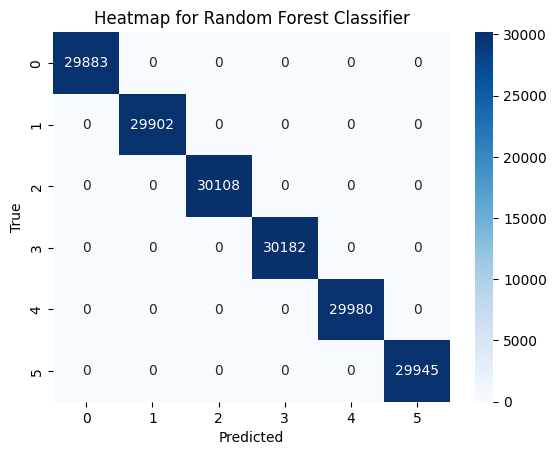

In [ ]:
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap for Random Forest Classifier")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Perform cross-validation to evaluate the model's performance
scores = cross_val_score(model_reg, x_data, y_data, cv=5)

print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Cross-validation scores:  [0.44444444 1.         1.         1.         0.58333333]
Average cross-validation score:  0.8055555555555556


# Using Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
# Normalize the input data
scaler = StandardScaler()
X = scaler.fit_transform(x_data)

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)

# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [ ]:
# Split data
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

In [ ]:
# Create the model
model = Sequential()
model.add(Dense(10, input_dim=7, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(dummy_y.shape[1], activation='softmax'))

# Compile model with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train_n, y_train_n, epochs=50, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
57600/57600 [==============================] - 232s 4ms/step - loss: 0.4054 - accuracy: 0.8384 - val_loss: 0.0954 - val_accuracy: 0.9722
Epoch 2/50
57600/57600 [==============================] - 162s 3ms/step - loss: 0.2556 - accuracy: 0.9138 - val_loss: 0.1189 - val_accuracy: 0.9722
Epoch 3/50
57600/57600 [==============================] - 153s 3ms/step - loss: 0.2296 - accuracy: 0.9249 - val_loss: 0.1455 - val_accuracy: 0.9722
Epoch 4/50
57600/57600 [==============================] - 153s 3ms/step - loss: 0.2193 - accuracy: 0.9270 - val_loss: 0.1236 - val_accuracy: 0.9722


In [ ]:
# Get the model's predictions
y_pred_n = model.predict(x_test_n)

# The predictions are probabilities, so convert them to class labels
y_pred_classes = np.argmax(y_pred_n, axis=1)

# Convert the one-hot encoded y_test back to class labels
y_test_classes = np.argmax(y_test_n, axis=1)

# Calculate the MSE
accuracy_n = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy Score: %.2f' % accuracy_n)

5625/5625 [==============================] - 9s 2ms/step
Accuracy Score: 0.97


# Using Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Create and Train the model
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42)
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=42)

In [ ]:
# Predict the values based on the testing data using the model
y_pred_test_log = logreg.predict(x_test)

In [ ]:
# Find the accuracy of the model
accuracy_log = accuracy_score(y_test, y_pred_test_log)
print('Accuracy: %.2f' % (accuracy_log))

Accuracy: 0.30


In [ ]:
# Find the classification report of the model for a better understanding
print(classification_report(y_test, y_pred_test_log))

                precision    recall  f1-score   support

      No fault       0.25      0.33      0.28     29883
    Root crack       0.25      0.33      0.28     29902
 chipped tooth       0.00      0.00      0.00     30108
  eccentricity       0.22      0.33      0.26     30182
 missing tooth       0.40      0.33      0.36     29980
surface defect       0.50      0.50      0.50     29945

      accuracy                           0.30    180000
     macro avg       0.27      0.30      0.28    180000
  weighted avg       0.27      0.30      0.28    180000



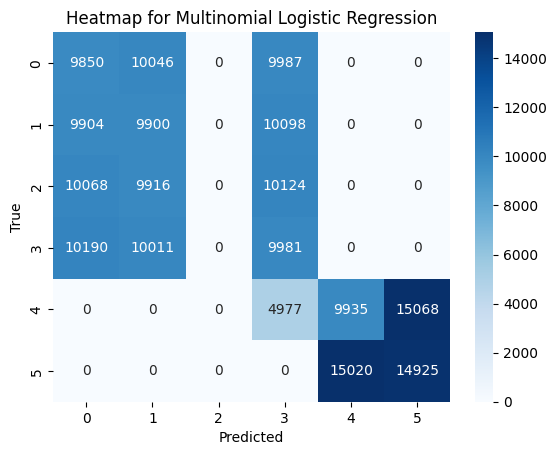

In [ ]:
#Plot a heatmap between the Predicted and the true values using the confusion matrix
cm_test_log = confusion_matrix(y_test, y_pred_test_log)
sns.heatmap(cm_test_log, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap for Multinomial Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Perform cross-validation to evaluate the model's performance
scores_log = cross_val_score(logreg, x_data, y_data, cv=5)

print("Cross-validation scores: ", scores_log)
print("Average cross-validation score: ", scores_log.mean())

Cross-validation scores:  [0.19444444 0.22222222 0.41666667 0.22222222 0.33333333]
Average cross-validation score:  0.27777777777777773


# Using K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
#Create and Train the model
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [ ]:
# Predict the values based on the testing data using the model
y_pred_test_knn = knn.predict(x_test)

In [ ]:
# Find the accuracy of the model
accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
print('Accuracy: %.2f' % (accuracy_knn))

Accuracy: 1.00


In [ ]:
# Find the classification report of the model for a better understanding
print(classification_report(y_test, y_pred_test_knn))  # Evaluate on test data

                precision    recall  f1-score   support

      No fault       1.00      1.00      1.00     29883
    Root crack       1.00      1.00      1.00     29902
 chipped tooth       1.00      1.00      1.00     30108
  eccentricity       1.00      1.00      1.00     30182
 missing tooth       1.00      1.00      1.00     29980
surface defect       1.00      1.00      1.00     29945

      accuracy                           1.00    180000
     macro avg       1.00      1.00      1.00    180000
  weighted avg       1.00      1.00      1.00    180000



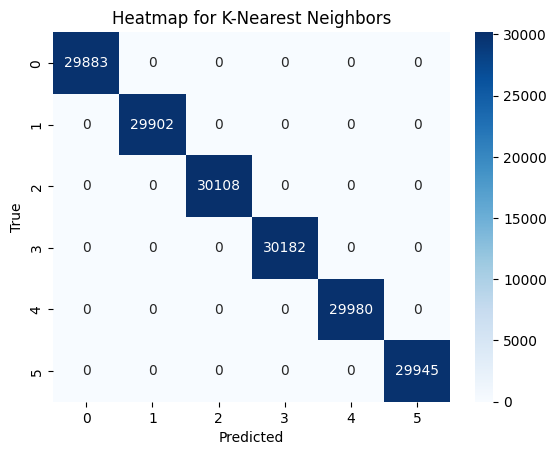

In [ ]:
#Plot a heatmap between the Predicted and the true values using the confusion matrix
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn)
sns.heatmap(cm_test_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap for K-Nearest Neighbors")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Perform cross-validation to evaluate the model's performance
scores_knn = cross_val_score(knn, x_data, y_data, cv=5)

print("Cross-validation scores: ", scores_knn)
print("Average cross-validation score: ", scores_knn.mean())

Cross-validation scores:  [0.44444444 1.         1.         1.         0.16666667]
Average cross-validation score:  0.7222222222222222


# Using Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Create and Train the model
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
clf.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)

In [ ]:
# Predict the values based on the testing data using the model
y_pred_test_clf = clf.predict(x_test)

In [ ]:
# Find the accuracy of the model
accuracy_clf = accuracy_score(y_test, y_pred_test_clf)
print('Accuracy: %.2f' % (accuracy_clf))

Accuracy: 1.00


In [ ]:
# Find the classification report of the model for a better understanding
print(classification_report(y_test, y_pred_test_clf))  # Evaluate on test data

                precision    recall  f1-score   support

      No fault       1.00      1.00      1.00     29883
    Root crack       1.00      1.00      1.00     29902
 chipped tooth       1.00      1.00      1.00     30108
  eccentricity       1.00      1.00      1.00     30182
 missing tooth       1.00      1.00      1.00     29980
surface defect       1.00      1.00      1.00     29945

      accuracy                           1.00    180000
     macro avg       1.00      1.00      1.00    180000
  weighted avg       1.00      1.00      1.00    180000



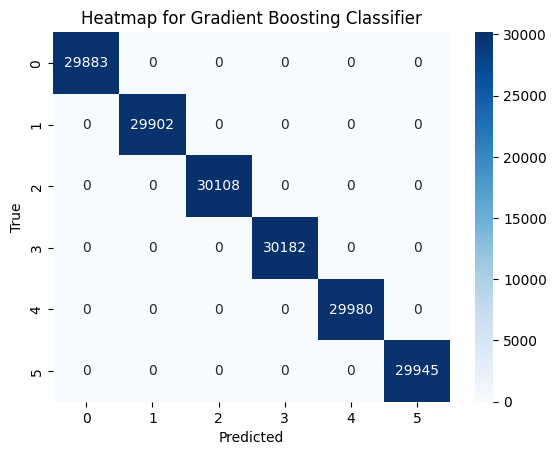

In [ ]:
#Plot a heatmap between the Predicted and the true values using the confusion matrix
cm_test_knn = confusion_matrix(y_test, y_pred_test_clf)
sns.heatmap(cm_test_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap for Gradient Boosting Classifier")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Perform cross-validation to evaluate the model's performance
scores_knn = cross_val_score(knn, x_data, y_data, cv=5)

print("Cross-validation scores: ", scores_knn)
print("Average cross-validation score: ", scores_knn.mean())

Cross-validation scores:  [0.44444444 1.         1.         1.         0.16666667]
Average cross-validation score:  0.7222222222222222


### The models that we've used and the accuracy of each are:
1. Random Forest Classifiers with 3 predictors  
    - Accuracy: 31%
    - Average cross-validation score: 77.8%
2. Random Forest Classifiers with 7 predictors
    - Accuracy: 100%
    - Average cross-validation score: 80.56%
3. Neural Networks     
    - Accuracy: 97%
4. Multinomial Linear Regression                
    - Accuracy: 30%
    - Average cross-validation score: 27.77%
5. K-Nearest Neighbours                         
    - Accuracy: 100%
    - Average cross-validation score: 72.22%
6. Gradient Boosting Classifier
    - Accuracy: 100%
    - Average cross-validation score: 72.22%
